In [1]:
from os.path import join as pjoin
from os.path import exists as exist
from os.path import isfile
from os import listdir as lsdir
from os import makedirs
from obspy.taup import TauPyModel
import obspy
import matplotlib.pyplot as plt
import numpy as np
from obspy.signal.cross_correlation import xcorr_max, correlate
import scipy.signal as signal
from obspy.geodetics import gps2dist_azimuth
from obspy.geodetics import kilometer2degrees
from scipy.optimize import minimize
import re

import SS_MTI
import Create_Vmod
from EventInterface import EventObj
import subprocess
from SS_MTI import PostProcessing as _PostProcessing
from SS_MTI import PreProcess as _PreProcess
from SS_MTI import PhaseTracer as _PhaseTracer
from SS_MTI import Gradient as _Gradient

In [2]:
def Get_location(la_s, lo_s, la_r, lo_r, radius=3389.5, flattening=0):
    """
    Get the epicentral distance, azimuth and backazimuth
    """
    dist, az, baz = gps2dist_azimuth(
        lat1=la_s, lon1=lo_s, lat2=la_r, lon2=lo_r, a=radius, f=flattening
    )
    epi = kilometer2degrees(dist, radius=radius)
    return epi, az, baz

In [6]:
# path of the reclectivity binary:
bin_path = "/home/nienke/Documents/Research/SS_MTI/External_packages/reflectivity_Mars/SRC/test/crfl_sac"

""" Define starting parameters """
or_time = obspy.UTCDateTime("2020-3-10T12:00:00")
lat_src = 0
lon_src = 0
depth = 20.0
name = "Test_Event"

npz_file = "/home/nienke/Documents/Research/Data/npz_files/TAYAK.npz"
model = TauPyModel(npz_file)

lat_rec = -30
lon_rec = 0

dt = 0.025

epi, az, baz = Get_location(lat_src, lon_src, lat_rec, lon_rec)
epi_in_km = 1774.7380

m_rr0 = 0.2
m_tt0 = 0.8
m_pp0 = 0.0
m_rt0 = 0.0
m_rp0 = 0.0
m_tp0 = 0.0
focal_mech0 = [m_rr0, m_tt0, m_pp0, m_rt0, m_rp0, m_tp0]

phases = ["P", "P", "S", "S", "S"]
comps = ["Z", "R", "Z", "R", "T"]
t_pres = [1, 1, 1, 1, 1]
t_posts = [30, 30, 30, 30, 30]
ylims = [1e-9, 1e-9, 2e-9, 3e-9, 2e-9]

fmin = 0.2
fmax = 0.6
zerophase = False

# This is basically your prior model, you need to set this up once:
save_path = (
    "/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/"
)


""" Create observed data array (for the moment all synthetic)"""
path_observed = (
    "/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/obs/"
)
st_obs = _Gradient.read_refl_mseeds(path_observed, stack=False)
""" Travel times of observed data """
npz_file = "/home/nienke/Documents/Research/Data/npz_files/TAYAK.npz"
Taup = TauPyModel(npz_file)
obs_tts = []
for i, phase in enumerate(phases):
    obs_tts.append(_PhaseTracer.get_traveltime(Taup, phase, depth, epi))
""" Window the observed data """
st_obs_w = obspy.Stream()  # keep this one for plotting
st_obs_full = obspy.Stream()
for i, phase in enumerate(phases):
    tr_full = st_obs.select(channel=f"xx{comps[i]}")[0].copy()
    if fmin is not None and fmax is not None:
        _PreProcess.filter_tr(tr_full, fmin=fmin, fmax=fmax, zerophase=zerophase)
    o_time = tr_full.stats.starttime
    tr = tr_full.slice(
        starttime=o_time + obs_tts[i] - t_pres[i],
        endtime=o_time + obs_tts[i] + t_posts[i],
    )
    st_obs_w += tr
    st_obs_full += tr_full


""" """
# check if folder exists:
if not exist(save_path):
    makedirs(save_path)
# check if folder is empty
if not lsdir(save_path):
    subprocess.call(f"scp {bin_path} .", shell=True, cwd=save_path)
bm_file_path = "/home/nienke/Documents/Research/Data/MTI/MT_vs_STR/bm_models/TAYAK.bm"
Create_Vmod.create_dat_file(
    src_depth=depth,
    focal_mech=focal_mech0,
    M0=None,
    epi_in_km=epi_in_km,
    baz=baz,
    dt=dt,
    save_path=save_path,
    bm_file_path=bm_file_path,
)

""" Get the parameter (m) array ready """
import pandas as pd

dat_path = pjoin(save_path, "crfl.dat")
dat_file = pd.read_csv(
    dat_path,
    skiprows=3,
    skipfooter=11 + 7,
    header=None,
    delim_whitespace=True,
    engine="python",
)

with open(dat_path, "r+") as f:
    data = f.readlines()
    f.close()
moment_param = np.array(data[-8].split(), dtype=float)
depths = dat_file.values[0:10:2, 0] + 10.0
MOHO = 77.3680  # depths[5]
vp = dat_file.values[0:10:2, 1] + dat_file.values[0:10:2, 1] * 0.01
vs = dat_file.values[0:10:2, 3] + dat_file.values[0:10:2, 3] * 0.01

"""
4 different cases that you can try:
1. Changing only the MOHO depth (depth = True, vpvs = False)
2. Changing the depths only (depth = True, vpvs = False) 
3. Changing the vpvs only (depth = False, vpvps = True)
4. Changing the depth and vpvps (depth = True, vpvps = True)
"""
m0 = np.hstack((moment_param, MOHO))  # Case 1
# m0 = np.hstack((moment_param, depths)) # Case 2
# m0 = np.hstack((np.hstack((moment_param, vp)), vs)) # Case 3
# m0 = np.hstack((np.hstack((np.hstack((moment_param, depths)), vp)), vs)) # Case 4

print(focal_mech0)
print(m0)

depth = True
vpvs = False

[0.2, 0.8, 0.0, 0.0, 0.0, 0.0]
[  0.8     0.      0.      0.      0.      0.2    77.368]


/home/nienke/Documents/Research/SS_MTI/Scripts_MT_Structure/Create_Vmod.py:292: RuntimeWarning: divide by zero encountered in double_scalars
  qp = 1 / (L * (1 / qmu) + (1 - L) * (1 / qka))
/home/nienke/Documents/Research/SS_MTI/Scripts_MT_Structure/Create_Vmod.py:292: RuntimeWarning: invalid value encountered in double_scalars
  qp = 1 / (L * (1 / qmu) + (1 - L) * (1 / qka))


# BFGS

In [ ]:
""" 
Start the misfit function with your initial model 
(i.e., it will run the forward model and calculates the misfit)
"""
n_it = 10
fac = 0.5  # factor that you want to multiply with the gradient
epsilon = 0.01
xis = np.zeros(n_it)
dxi_dms = np.zeros((len(m0), n_it))
m0s = np.zeros((len(m0), n_it + 1))
m0s[:, 0] = m0

sigma = 1e-10

src_str = _Gradient.SRC_STR(
    binary_file_path=bin_path,
    path_to_dat=save_path,
    phases=phases,
    components=comps,
    t_pres=t_pres,
    t_posts=t_posts,
    depth=depth,
    vpvs=vpvs,
    fmin=fmin,
    fmax=fmax,
    dt=dt,
    baz=baz,
    sigma = sigma,
    zerophase=zerophase,
    plot=True,
    st_obs_full=st_obs_full,
    tt_obs=obs_tts,
    ylims=ylims,
)
eps_array = epsilon * np.array(
    [
        np.mean(m0[:-1]),
        np.mean(m0[:-1]),
        np.mean(m0[:-1]),
        np.mean(m0[:-1]),
        np.mean(m0[:-1]),
        np.mean(m0[:-1]),
        m0[-1],
    ]
)
print(m0)

res = minimize(
    src_str.misfit,
    m0,
    st_obs_w,
    method="BFGS",
    options={"maxiter": 2, "eps": eps_array, "return_all": True, "gtol": 1e-8, "disp":True},
)

[  0.8     0.      0.      0.      0.      0.2    77.368]
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...
17.036103918
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...
17.036103918
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...
16.9589235109
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...
17.0361282927
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building 

/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


17.838409005
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


17.864356111
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


17.8657737198
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


17.8643355124
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


17.8643500533
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


17.8967823715
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


54.8176314612
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


16.1541056505
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


16.1541056505
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


16.0829223372
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


16.1541313512
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


16.1820454039
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


16.1541056505
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


16.1541249593
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


16.213919698
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


52.4026042578
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8787036333
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8787036333
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8316344004
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8787267988
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8890234744
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8787036333
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8787220983
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.920995958
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


54.0698302731
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


20.139410826
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


20.139410826
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


20.1115587707
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


20.1394290979
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


20.1489031492
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


20.139410826
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


20.1394237229
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


20.1715991171
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


54.3113945404
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


16.1064470475
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


16.1064470475
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


16.0606815037
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


16.106469886
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


16.1167425629
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


16.1064470475
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


16.1064631744
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


16.1506605719
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


54.0991852023
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8760724744
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8760724744
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8289989854
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8760956437
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8863718838
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8760724744
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8760909425
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.920995958
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


54.0743932686
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8289989854
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733115093
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8835930822
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733068073
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9155667019
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


54.076249258
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


16.03206337
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


16.03206337
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9885500554
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


16.0320863148
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


16.0423779236
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


16.03206337
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


16.032079571
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


16.0765289937
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


54.0895145651
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9170965892
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9170965892
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8702428105
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9171196991
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9267946085
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9170965892
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9171150104
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9592780647
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


54.075157788
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8289989854
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733115093
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8835930822
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733068073
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9155667019
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


54.076249258
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8289989854
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733115093
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8835930822
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733068073
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9155667019
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


54.076249258
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9170965892
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9170965892
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8702428105
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9171196991
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9267946085
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9170965892
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9171150104
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9592780647
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


54.075157788
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8289989854
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733115093
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8835930822
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733068073
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9155667019
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


54.076249258
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8289989854
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733115093
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8835930822
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733068073
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9155667019
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


54.076249258
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8738718278
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8738718278
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8295682779
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8738950003
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8835930822
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8738718278
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8738902984
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9161630885
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


54.075157788
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8289989854
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733115093
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8835930822
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733068073
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9155667019
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


54.076249258
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8289989854
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733115093
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8835930822
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733068073
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9155667019
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


54.076249258
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8738718278
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8738718278
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8295682779
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8738950003
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8835930822
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8738718278
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8738902984
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9161630885
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


54.075157788
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8289989854
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733115093
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8835930822
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733068073
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9155667019
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


54.076249258
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8289989854
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733115093
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8835930822
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733068073
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9155667019
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


54.076249258
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8738718278
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8738718278
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8295682779
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8738950003
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8835930822
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8738718278
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8738902984
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9161630885
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


54.075157788
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8289989854
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733115093
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8835930822
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733068073
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9155667019
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


54.076249258
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8289989854
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733115093
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8835930822
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733068073
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9155667019
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


54.076249258
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8738718278
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8738718278
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8295682779
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8738950003
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8835930822
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8738718278
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8738902984
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9161630885
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


54.075157788
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8289989854
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733115093
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8835930822
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733068073
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9155667019
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


54.076249258
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8289989854
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733115093
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8835930822
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733068073
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9155667019
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


54.076249258
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8289989854
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733115093
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8835930822
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733068073
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9155667019
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


54.076249258
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8289989854
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733115093
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8835930822
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733068073
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9155667019
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


54.076249258
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8289989854
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733115093
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8835930822
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733068073
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9155667019
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


54.076249258
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8289989854
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733115093
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8835930822
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733068073
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9155667019
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


54.076249258
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8289989854
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733115093
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8835930822
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733068073
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9155667019
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


54.076249258
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8738718278
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8738718278
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8295682779
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8738950003
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8835930822
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8738718278
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8738902984
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9161630885
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


54.075157788
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8289989854
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733115093
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8835930822
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733068073
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9155667019
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


54.076249258
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8289989854
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733115093
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8835930822
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733068073
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9155667019
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


54.076249258
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8289989854
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733115093
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8835930822
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733068073
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9155667019
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


54.076249258
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8289989854
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733115093
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8835930822
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733068073
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9155667019
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


54.076249258
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8289989854
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733115093
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8835930822
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.873288336
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8733068073
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.9155667019
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


54.076249258
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8738718278
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8738718278
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8295682779
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=len(phases), ncols=1, sharex="all", figsize=(18, 20))


15.8738950003
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


In [1]:
np.array(res.allvecs).T 


NameError: name 'np' is not defined

model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...
0.806267271052
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...
0.806267271052
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...
0.810215773354
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...
0.80627622453
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research

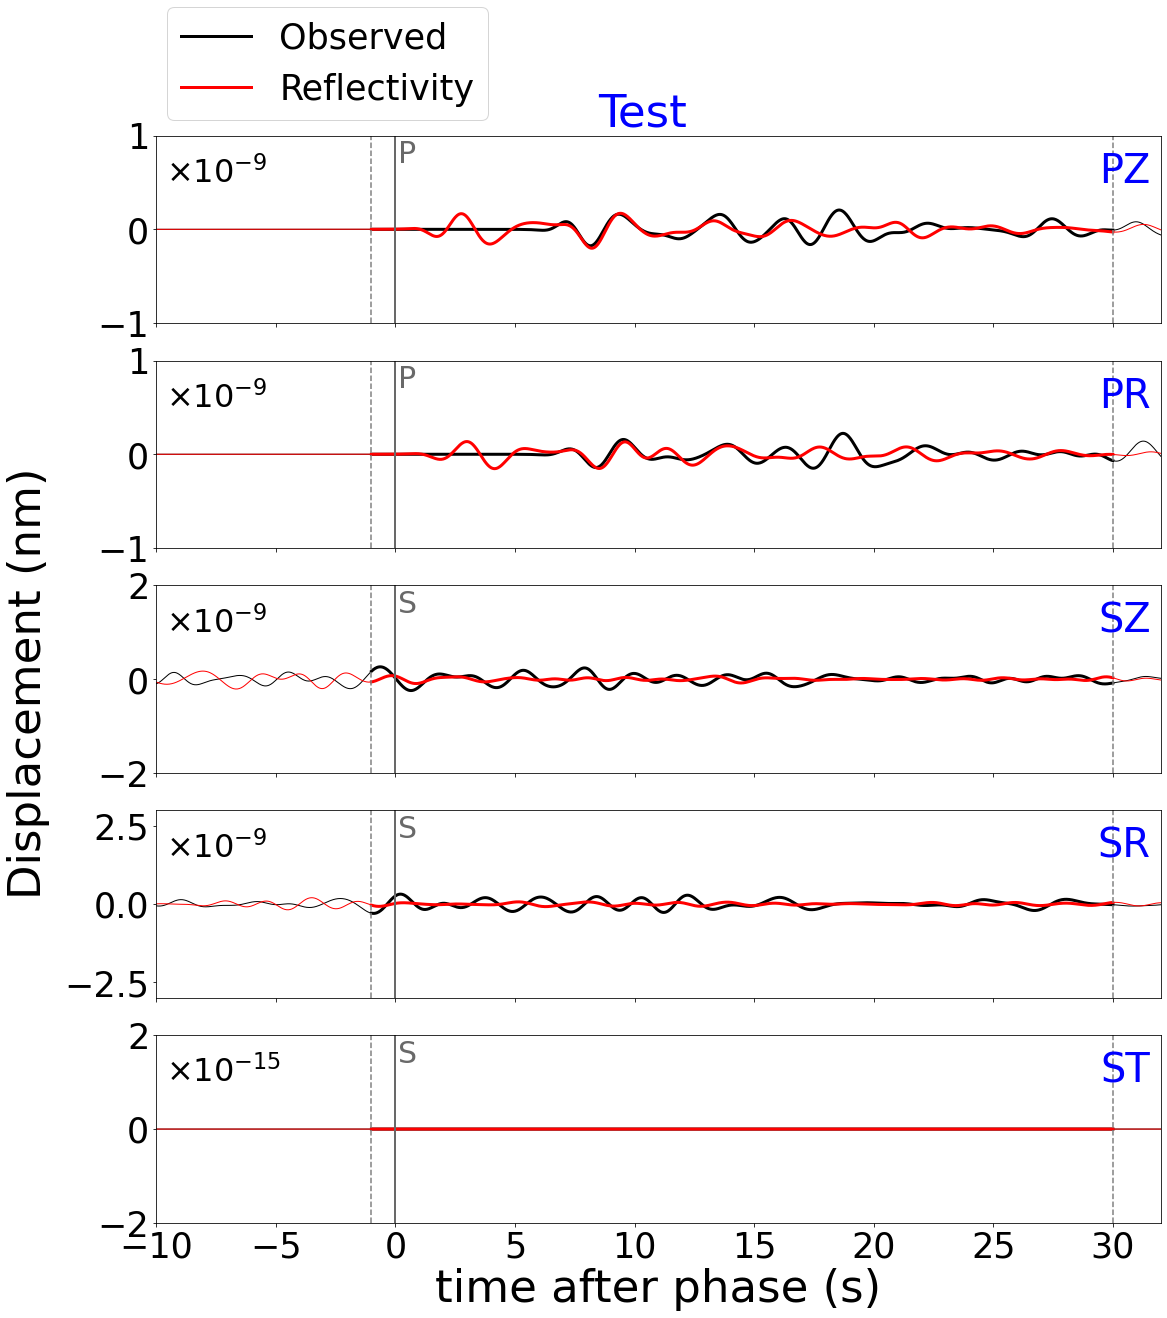

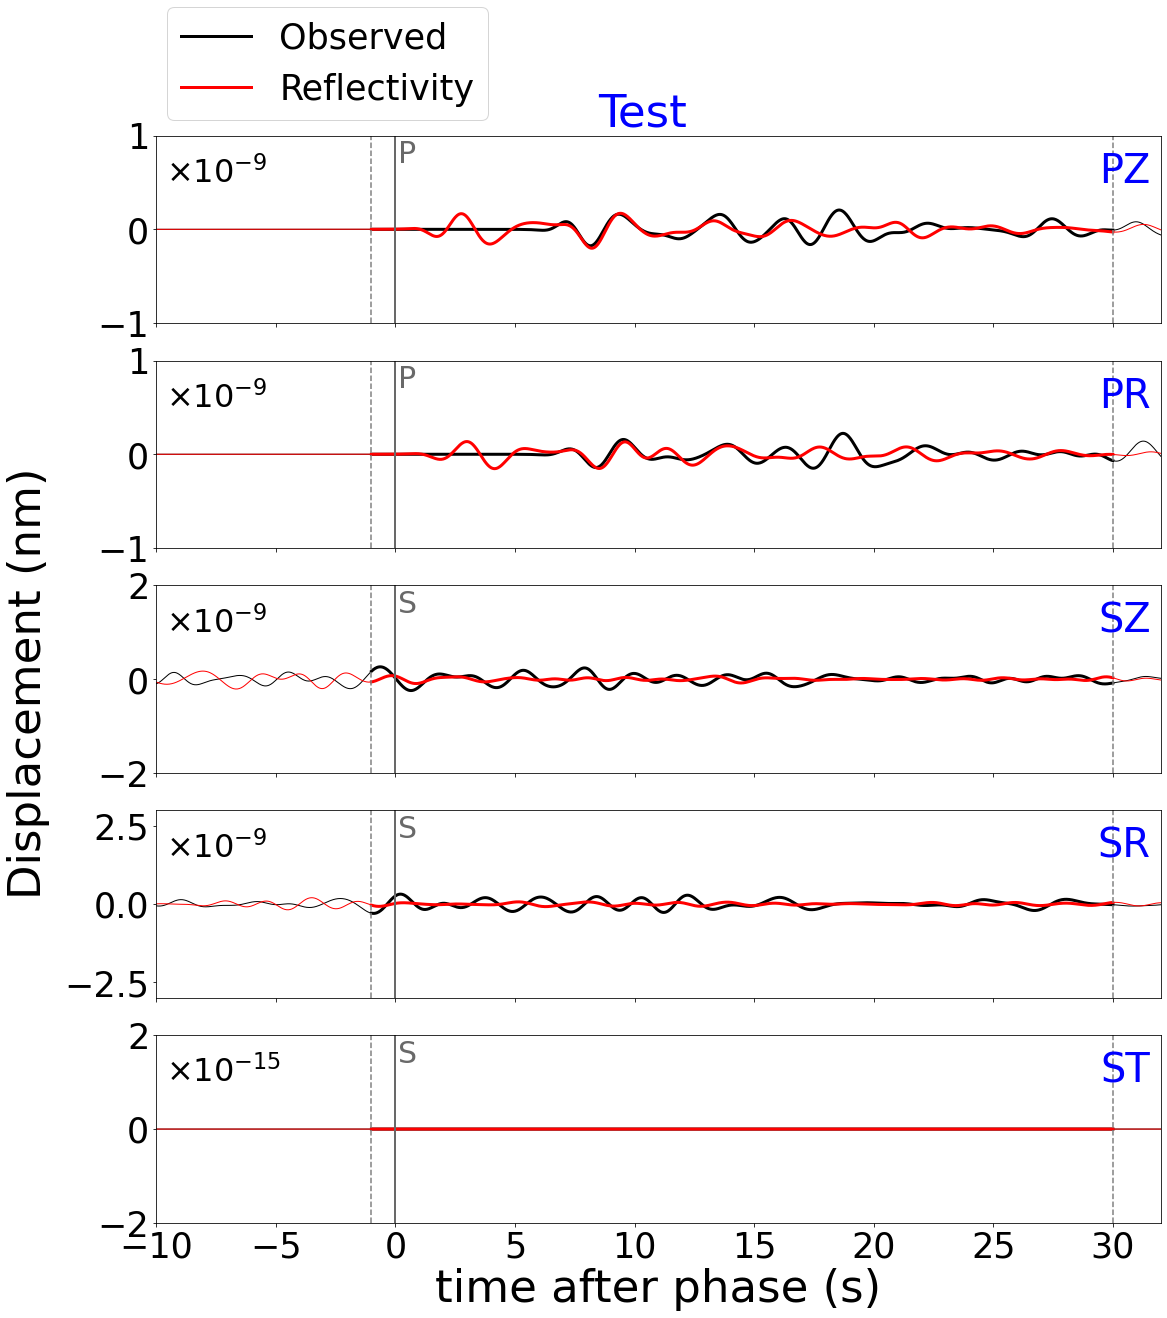

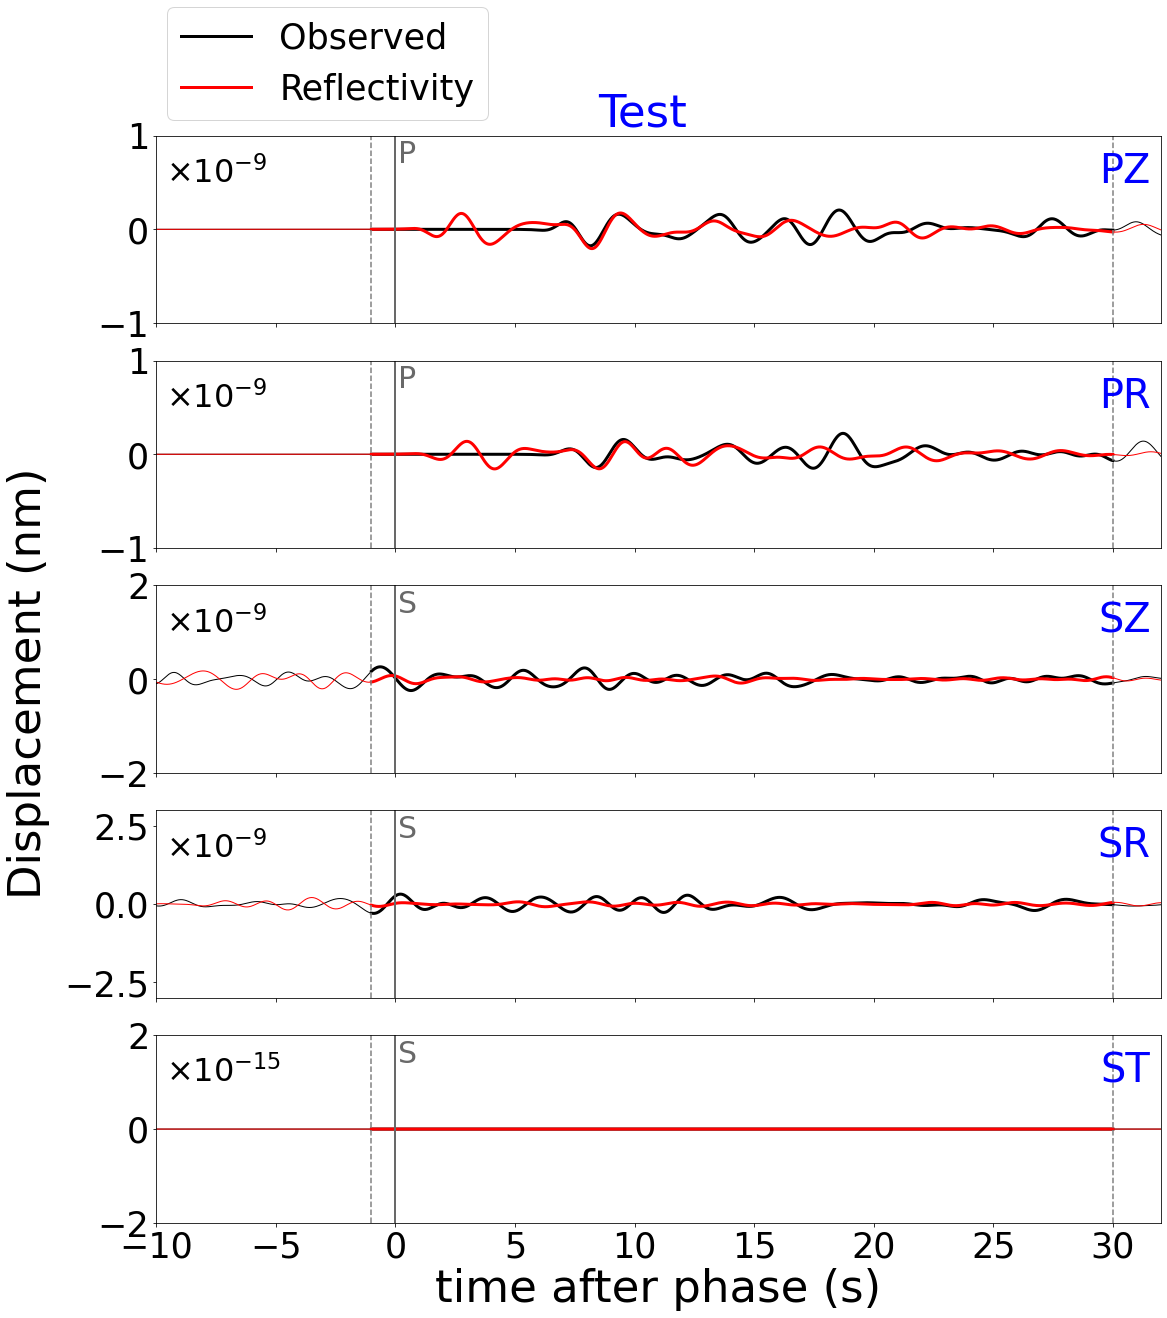

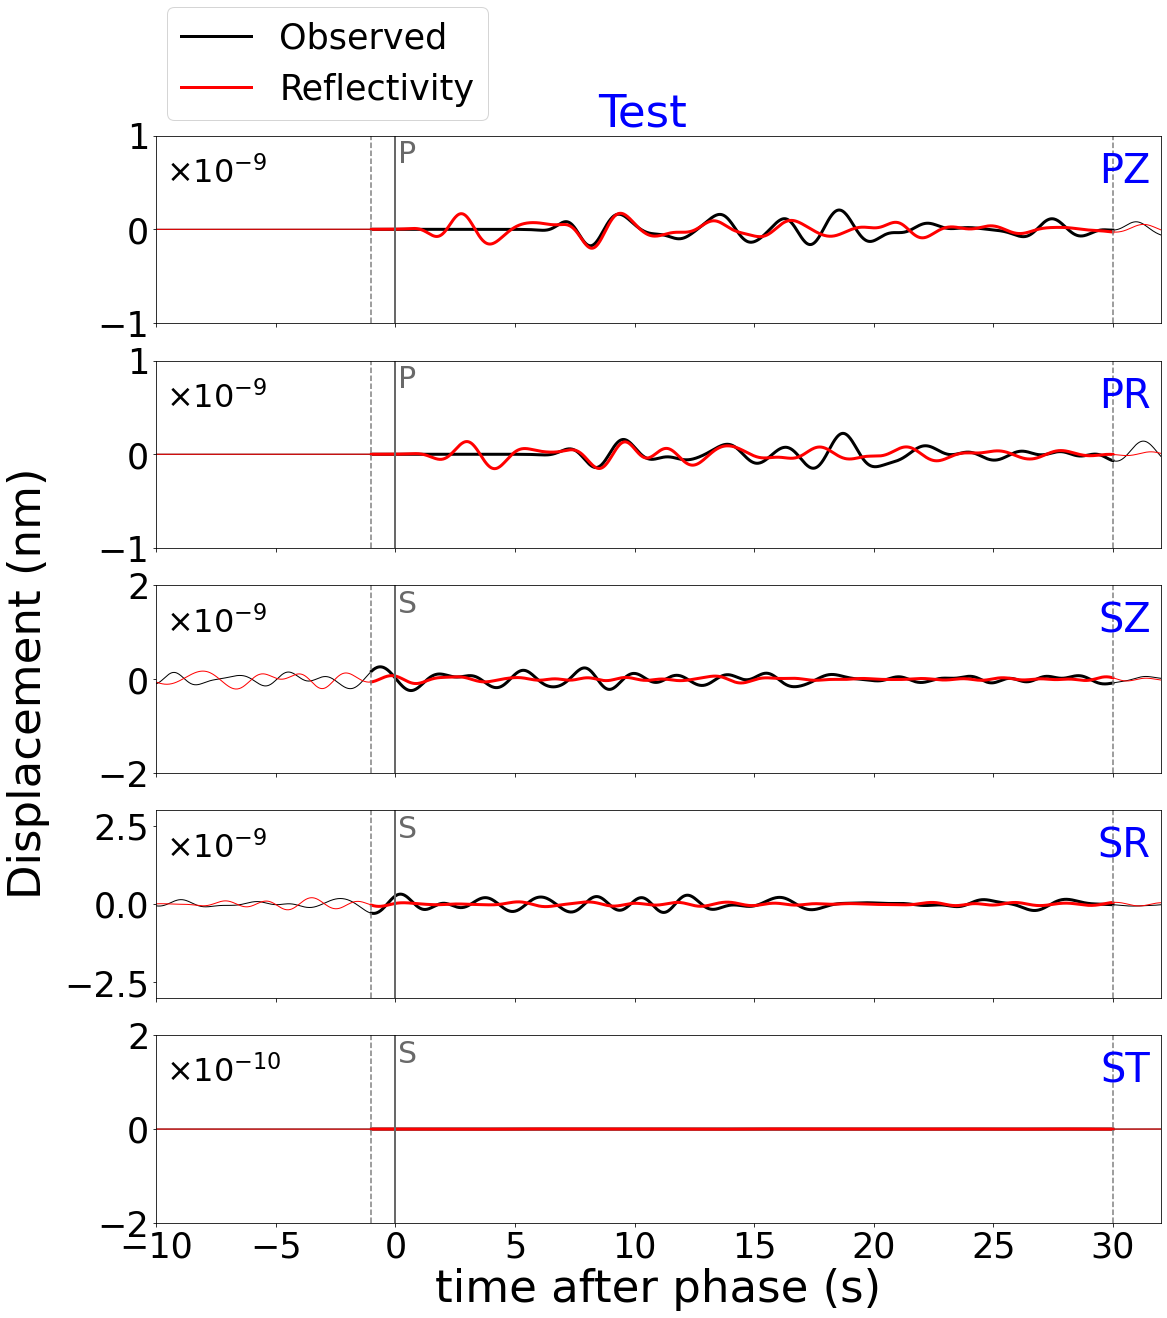

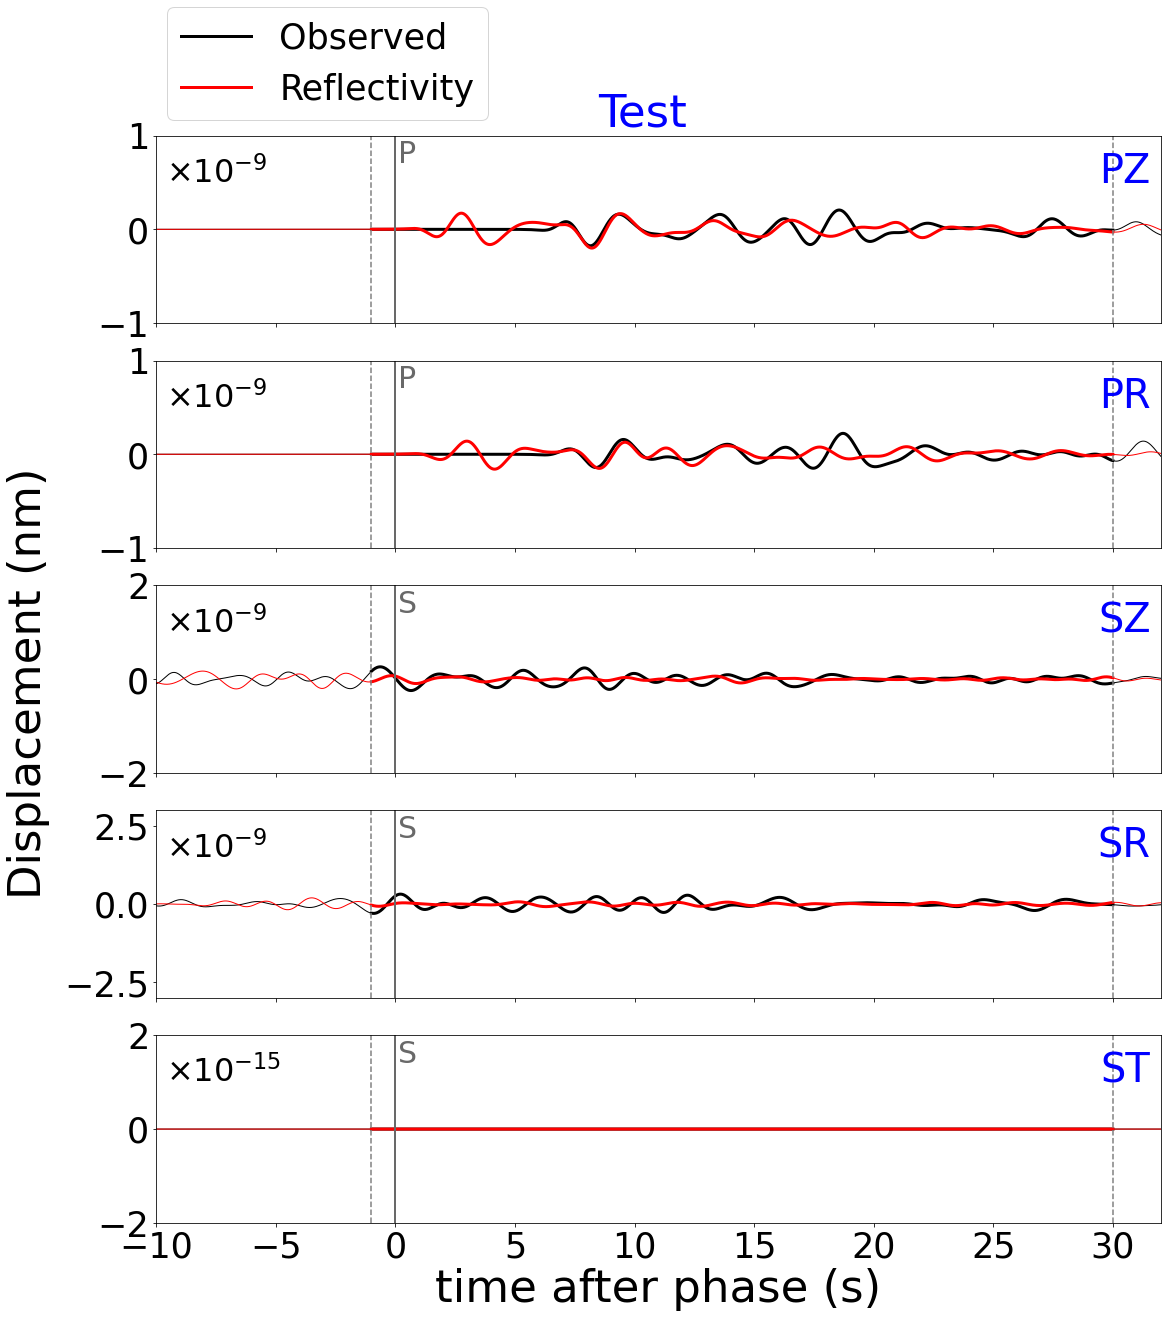

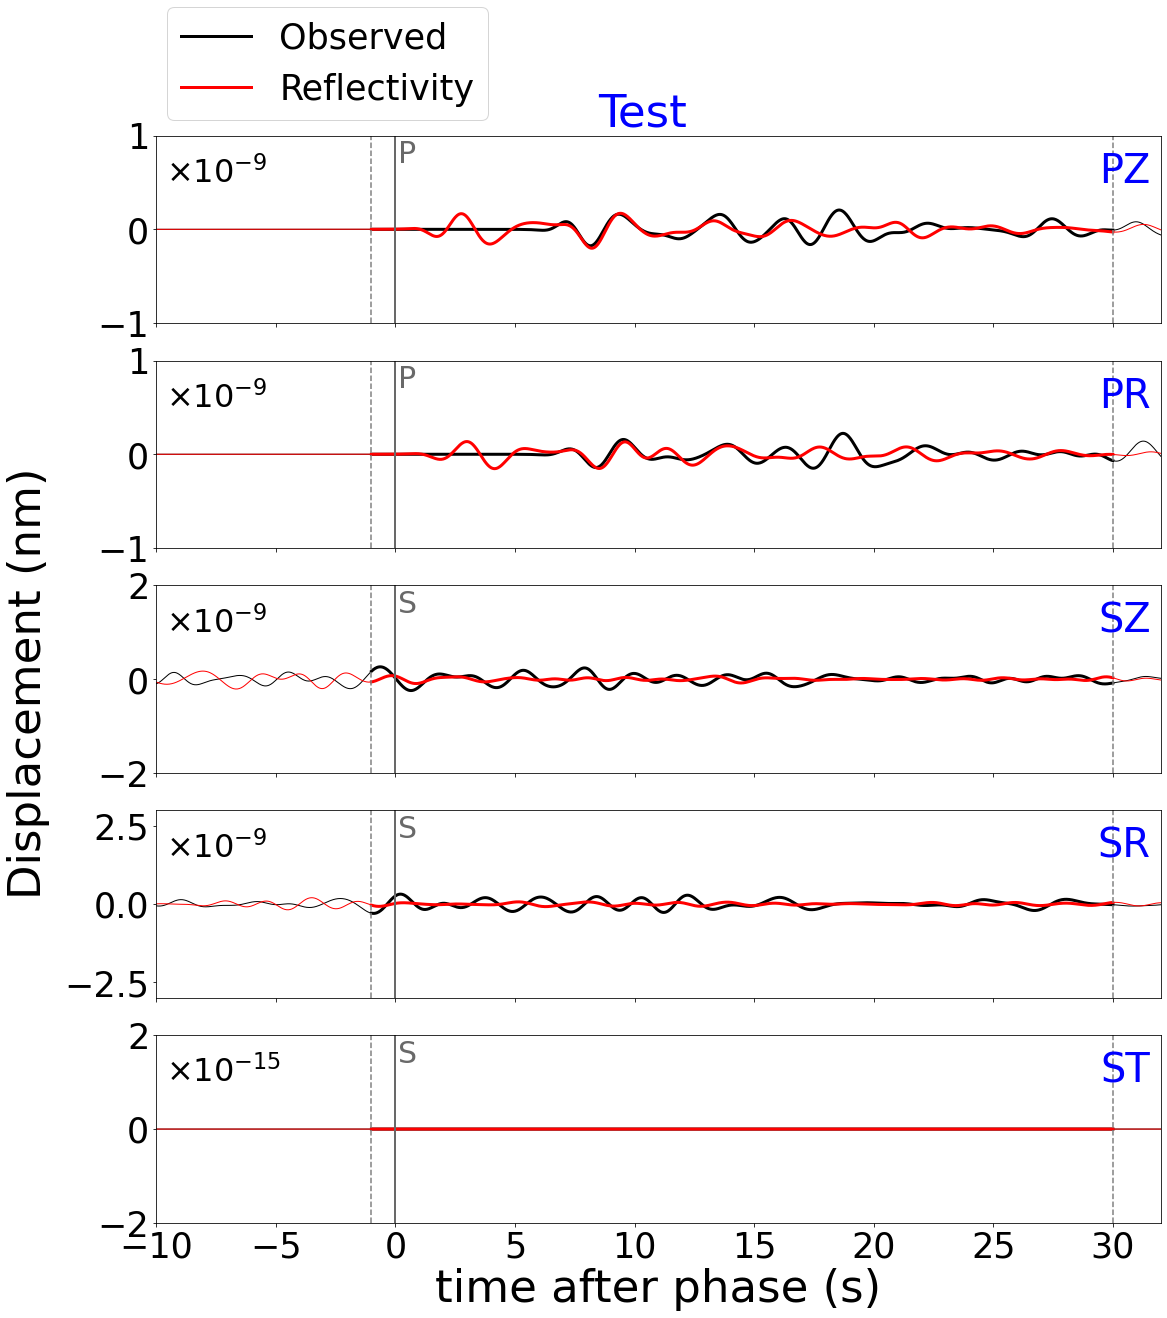

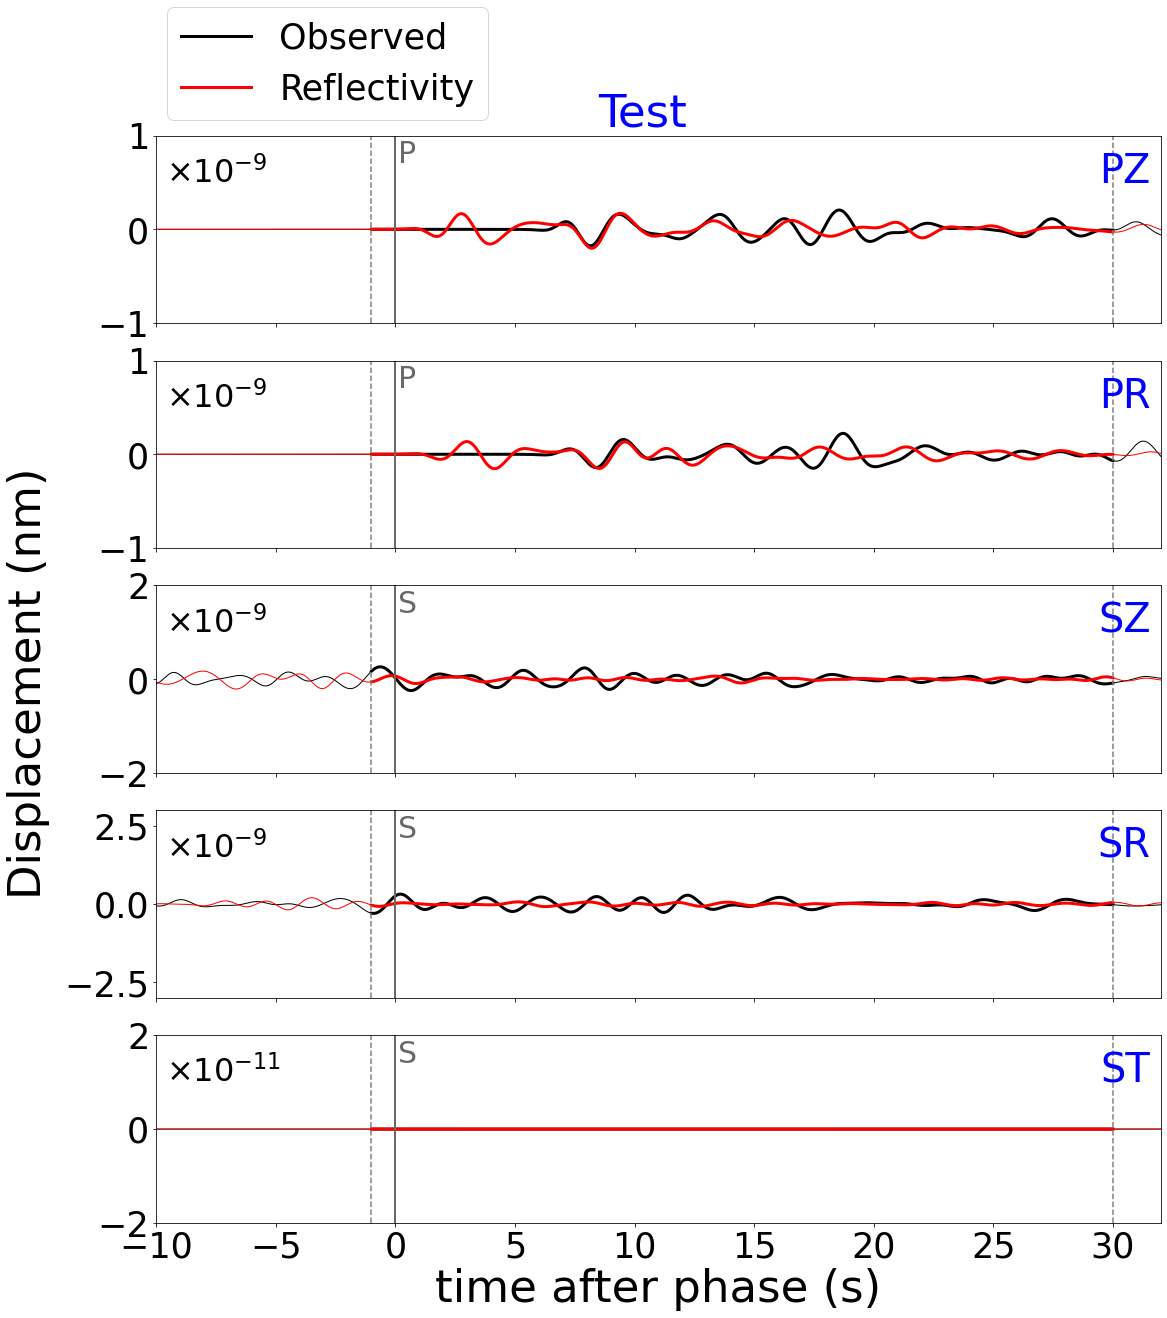

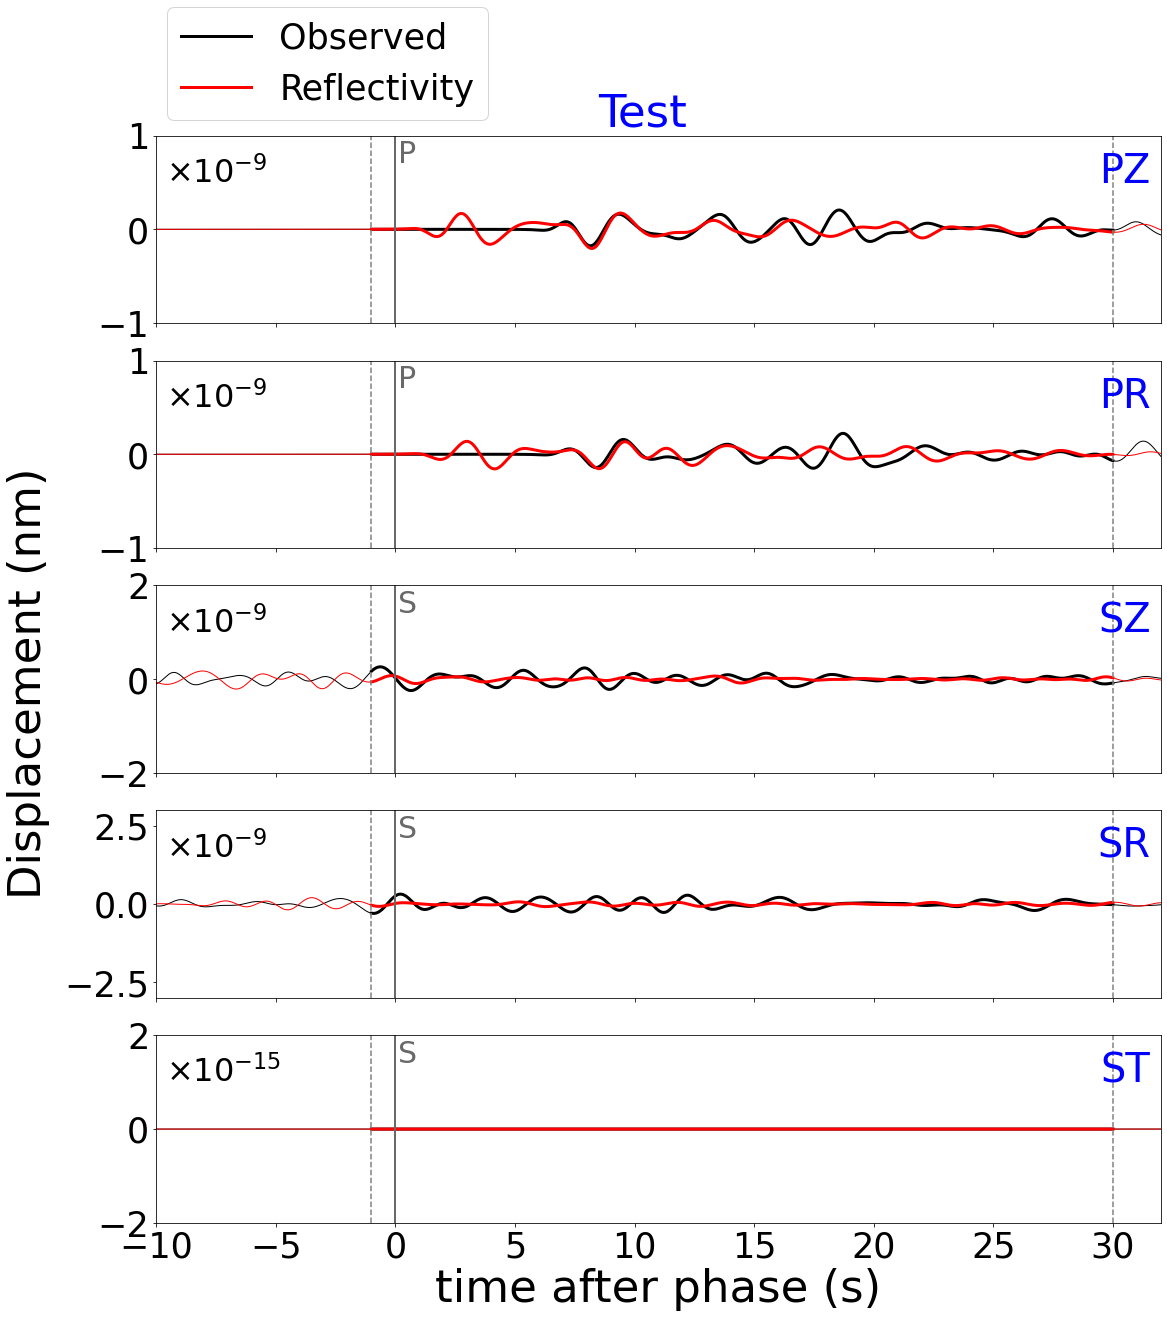

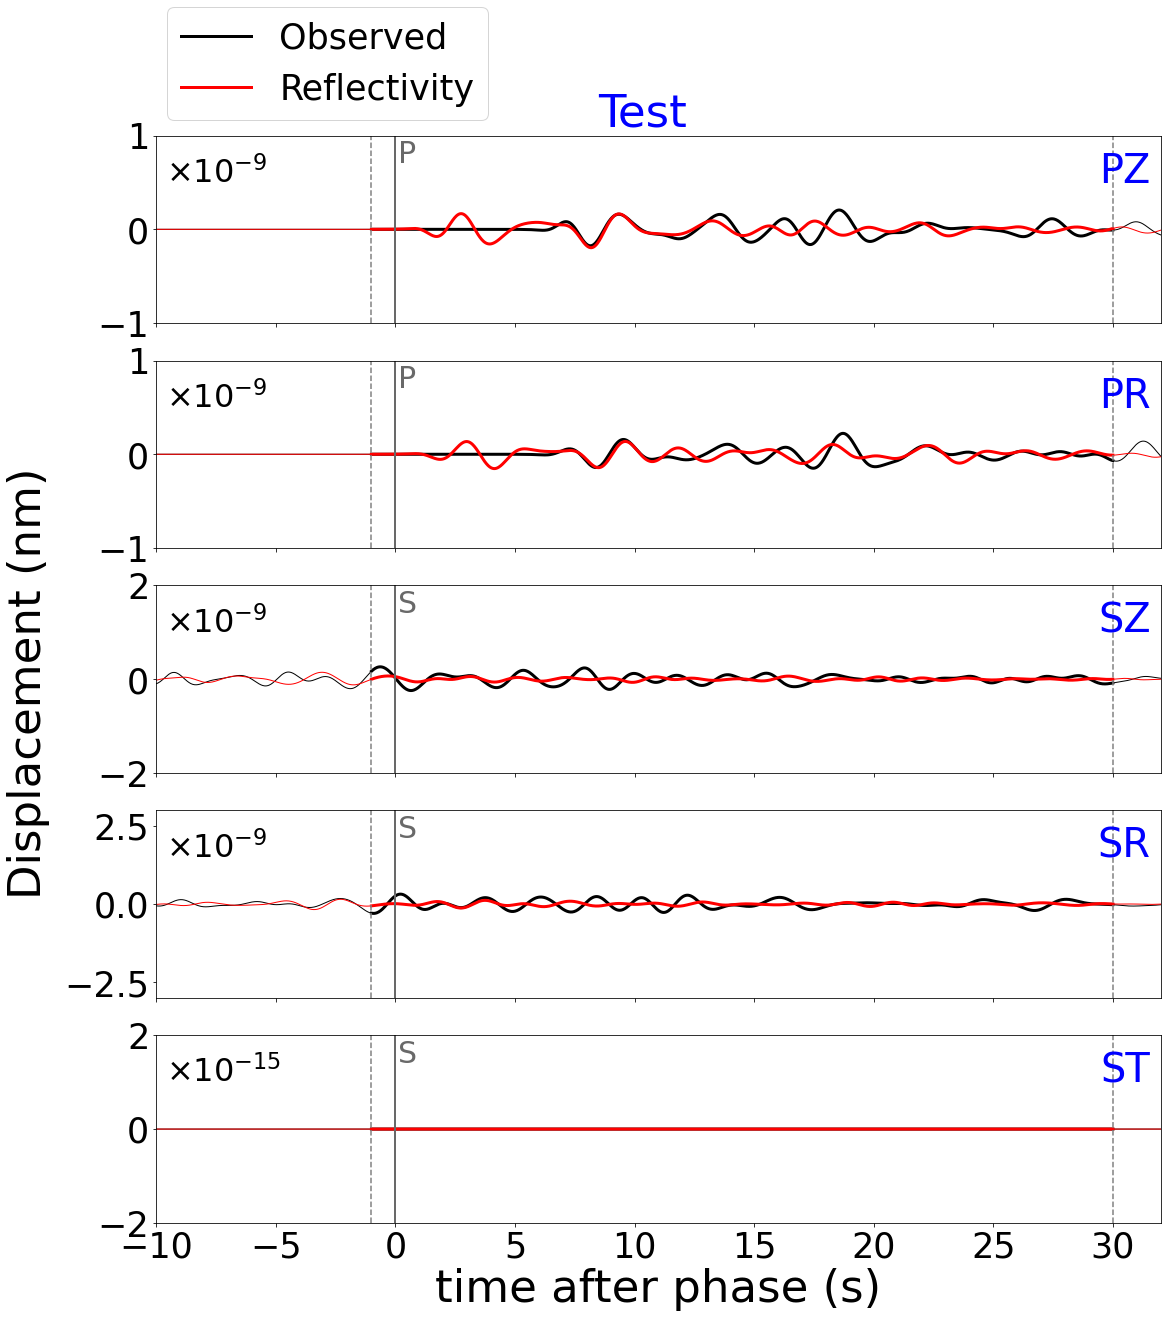

In [21]:

sigma = 1e-8

src_str = _Gradient.SRC_STR(
    binary_file_path=bin_path,
    path_to_dat=save_path,
    phases=phases,
    components=comps,
    t_pres=t_pres,
    t_posts=t_posts,
    depth=depth,
    vpvs=vpvs,
    fmin=fmin,
    fmax=fmax,
    dt=dt,
    baz=baz,
    sigma = sigma,
    zerophase=zerophase,
    plot=True,
    st_obs_full=st_obs_full,
    tt_obs=obs_tts,
    ylims=ylims,
)
eps_array = epsilon * np.array(
    [
        np.mean(m0[:-1]),
        np.mean(m0[:-1]),
        np.mean(m0[:-1]),
        np.mean(m0[:-1]),
        np.mean(m0[:-1]),
        np.mean(m0[:-1]),
        m0[-1],
    ]
)
res2 = minimize(
    src_str.misfit,
    m0,
    st_obs_w,
    method="BFGS",
    options={"maxiter": 10, "eps": eps_array, "return_all": True, "gtol": 8e0, "disp":True},
)

In [2]:
res2

NameError: name 'res2' is not defined

# Line-search

In [ ]:
from scipy.optimize import line_search

# Open the misfit values

In [22]:
import numpy as np
from os.path import join as pjoin

In [23]:
file_path = (
    "/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/"
)

In [24]:
xis = np.load(pjoin(file_path, "dxi_dms.npy"))

In [25]:
xis

array([[  2.39233334e+01,  -4.52528758e+01,   3.05425008e+01],
       [  5.56758832e-03,  -1.42113072e-02,   9.57546346e-03],
       [  3.20080117e+00,  -2.04431892e+01,   5.26008338e+01],
       [  0.00000000e+00,   7.32781343e-10,  -2.65512877e-10],
       [  3.96132787e-03,  -1.02951653e-02,   6.58079517e-03],
       [  1.60106010e+01,  -2.21807573e+01,   2.00212896e+01],
       [ -6.17949737e+00,  -2.25046259e+01,   5.82279100e+01]])

In [26]:
ms = np.load(pjoin(file_path, "m0s.npy"))

In [27]:
ms.T

array([[  5.00000000e-01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   5.00000000e-01,
          5.00000000e+01],
       [ -1.14616667e+01,  -2.78379416e-03,  -1.60040058e+00,
          0.00000000e+00,  -1.98066394e-03,  -7.50530049e+00,
          5.30897487e+01],
       [  1.11647712e+01,   4.32185944e-03,   8.62119400e+00,
         -3.66390671e-10,   3.16691871e-03,   3.58507816e+00,
          6.43420616e+01],
       [ -4.10647921e+00,  -4.65872289e-04,  -1.76792229e+01,
         -2.33634233e-10,  -1.23478875e-04,  -6.42556662e+00,
          3.52281066e+01]])

In [29]:
# m0 = ms.T[0, :]
# 0.1
# * np.array(
#     [
#         np.mean(m0[:-1]),
#         np.mean(m0[:-1]),
#         np.mean(m0[:-1]),
#         np.mean(m0[:-1]),
#         np.mean(m0[:-1]),
#         np.mean(m0[:-1]),
#         m0[-1],
#     ]
# )

In [30]:
xis = np.load(pjoin(file_path, "xis.npy"))

In [31]:
xis

array([  80.62672711,  708.16636307,  871.16019469])